# Get Titannic Data Sets

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Import libraries, packages & modules

In [2]:
# General libraries.
import os
import pandas as pd
import numpy as np
import timeit
import re
import itertools
from itertools import chain 
import httplib2
from datetime import date, timedelta

# Saving and opening files
import zipfile
import pickle
# from logging import handlers
# import logging

# Plotting/Visualizing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
# import mglearn
from matplotlib.gridspec import GridSpec

# sklearn - pre-processing
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import KBinsDiscretizer

# sklearn - pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# sklear - vectorizing and transforming
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#sklearn - models
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

# sklearn - analysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# sklearn - calibration
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve


# Exploratory Data Analysis

In [3]:
# Create dataframe for training data
path = '/kaggle/input/titanic/'
df = pd.read_csv(path +'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Remove 'the' from Name column'
df['Name'] = df['Name'].str.replace('the ','',regex=True)
# Create unique list of titles
pat1 = '(?<=,\s)(\w+)'
df['Title'] = df['Name'].str.extract(pat1)
titles = df['Title'].unique().tolist()

# Assign numbers to titles
num_titles = range(len(titles))
title_and_num = []
for x,y in zip(titles,num_titles):
    lst = [x,y]
    title_and_num.append(lst)
title_and_num

[['Mr', 0],
 ['Mrs', 1],
 ['Miss', 2],
 ['Master', 3],
 ['Don', 4],
 ['Rev', 5],
 ['Dr', 6],
 ['Mme', 7],
 ['Ms', 8],
 ['Major', 9],
 ['Lady', 10],
 ['Sir', 11],
 ['Mlle', 12],
 ['Col', 13],
 ['Capt', 14],
 ['Countess', 15],
 ['Jonkheer', 16]]

In [5]:
for z in title_and_num:
    df.loc[df['Title'].str.contains(z[0]),'Title_num'] = z[1]
df['Title_num'] = df['Title_num'].astype('category')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0.0


<AxesSubplot:ylabel='Title'>

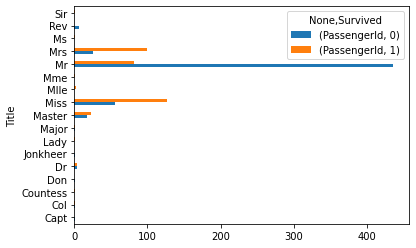

In [6]:
# Analyze survival rate by title
surv_by_title = df[['Survived','Title','PassengerId']].pivot_table(index=['Title'],columns=['Survived'],values=['PassengerId'],aggfunc = 'count')
surv_by_title.sort_values(by=['Title'],ascending=True,inplace=True)
surv_by_title.plot.barh()

In [7]:
# Create column for titles
for title in titles:
    df.loc[df['Name'].str.contains(title),'Title'] = title
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0.0


In [8]:
# View tickets
tickets = df['Ticket'].unique()
np.sort(tickets)

array(['110152', '110413', '110465', '110564', '110813', '111240',
       '111320', '111361', '111369', '111426', '111427', '111428',
       '112050', '112052', '112053', '112058', '112059', '112277',
       '112379', '113028', '113043', '113050', '113051', '113055',
       '113056', '113059', '113501', '113503', '113505', '113509',
       '113510', '113514', '113572', '113760', '113767', '113773',
       '113776', '113781', '113783', '113784', '113786', '113787',
       '113788', '113789', '113792', '113794', '113796', '113798',
       '113800', '113803', '113804', '113806', '113807', '11668', '11751',
       '11752', '11753', '11755', '11765', '11767', '11769', '11771',
       '11774', '11813', '11967', '12233', '12460', '12749', '13049',
       '13213', '13214', '13502', '13507', '13509', '13567', '13568',
       '14311', '14312', '14313', '14973', '1601', '16966', '16988',
       '17421', '17453', '17463', '17464', '17465', '17466', '17474',
       '17764', '19877', '19928', '19943

In [9]:
# Create unique list of ticket prefixes and numbers
ticket_alpha_pat = '(.*)[ ]\d+$'
ticket_num_pat = '(\d+)$'
df['Ticket_alpha'] = df['Ticket'].str.extract(ticket_alpha_pat)
df['Ticket_alpha'] = df['Ticket_alpha'].str.replace('[.,/]','',regex=True).str.lower().fillna(0)
df['Ticket_num'] = df['Ticket'].str.extract(ticket_num_pat).fillna(0).astype('int')
df['Ticket_len'] = df['Ticket'].apply(lambda x: len(x))

ticket_num = df['Ticket_num'].unique().tolist()
ticket_alpha = df['Ticket_alpha'].unique().tolist()
ticket_len = df['Ticket_len'].unique().tolist()
df_see = df[['Survived','PassengerId','Ticket','Ticket_alpha','Ticket_num','Ticket_len']].copy()
df_see

,Survived,PassengerId,Ticket,Ticket_alpha,Ticket_num,Ticket_len
0,0,1,A/5 21171,a5,21171,9
1,1,2,PC 17599,pc,17599,8
2,1,3,STON/O2. 3101282,stono2,3101282,16
3,1,4,113803,0,113803,6
4,0,5,373450,0,373450,6
...,...,...,...,...,...,...
886,0,887,211536,0,211536,6
887,1,888,112053,0,112053,6
888,0,889,W./C. 6607,wc,6607,10
889,1,890,111369,0,111369,6


In [10]:
# Inspect ticket prefixes
pt1 = pd.pivot_table(df_see,index=['Ticket_alpha'],columns=['Survived'],values=['PassengerId'],fill_value='-',aggfunc='count')
# pt1.sort_values(by='PassengerId'['1'],ascending=False)

In [11]:
# Inspect cabin codes
cabins = df['Cabin'].unique().astype(str)
np.sort(cabins)

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B28', 'B3', 'B30', 'B35', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55',
       'B57 B59 B63 B66', 'B58 B60', 'B69', 'B71', 'B73', 'B77', 'B78',
       'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103',
       'C104', 'C106', 'C110', 'C111', 'C118', 'C123', 'C124', 'C125',
       'C126', 'C128', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C30',
       'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64',
       'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D10 D12',
       'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30',
       'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49',
       'D50', 'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121',
       'E17',

In [12]:
# Create unique list of cabin prefixes and numbers
cabin_alpha_pat = '^(\w)'
df['Cabin_alpha'] = df['Cabin'].str.extract(cabin_alpha_pat)
cabin_num_pat = '(\d+)$'
df['Cabin_num'] = df['Cabin'].str.extract(cabin_num_pat).fillna(0).astype('int')
df['Cabin_alpha'].fillna(0,inplace=True)
df['Cabin_num'].fillna(0,inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_num,Ticket_alpha,Ticket_num,Ticket_len,Cabin_alpha,Cabin_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0.0,a5,21171,9,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1.0,pc,17599,8,C,85
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,2.0,stono2,3101282,16,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1.0,0,113803,6,C,123
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0.0,0,373450,6,0,0


<AxesSubplot:xlabel='Cabin_alpha'>

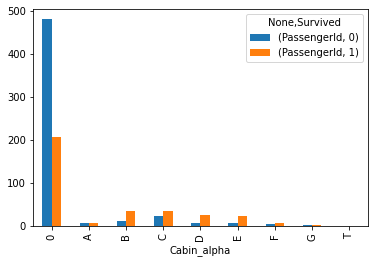

In [13]:
# Inspect cabin prefixes
ca_p = pd.pivot_table(df,index=['Cabin_alpha'],columns=['Survived'],values=['PassengerId'],aggfunc='count')
ca_p.plot.bar()

<AxesSubplot:>

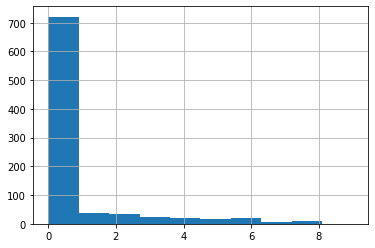

In [14]:
X_cabin_num = df['Cabin_num'].to_numpy().reshape(-1, 1)
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
Cabin_num_t = est.fit_transform(X_cabin_num)
df['Cabin_num_bin'] = Cabin_num_t
df['Cabin_num_bin'].hist()

<AxesSubplot:>

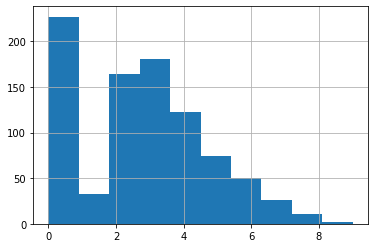

In [15]:
# Convert age values to bins
df['Age'] = df['Age'].fillna(0).astype('int')
X_age = df['Age'].to_numpy().reshape(-1, 1)
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_age_t = est.fit_transform(X_age)
df['Age_bin'] = X_age_t
df['Age_bin'].hist()

In [16]:
age_by_title = pd.pivot_table(df,index=['Title'],columns=['Age_bin'],values=['PassengerId'],fill_value='-',aggfunc='count')
age_by_title.sort_values(by='Title',ascending=True)

PassengerId                                                       
Age_bin          0.0   1.0    2.0    3.0   4.0   5.0   6.0   7.0   8.0  9.0
Title                                                                      
Capt               -     -      -      -     -     -     -     -   1.0    -
Col                -   1.0      -    5.0   1.0   1.0     -   2.0     -    -
Countess           -     -      -      -   1.0     -     -     -     -    -
Don                -     -      -      -     -   1.0   1.0     -     -    -
Dr               2.0     -    1.0      -   4.0   1.0   3.0     -     -    -
Jonkheer           -     -      -      -   1.0     -     -     -     -    -
Lady               -     -      -      -     -     -   1.0     -     -    -
Major              -     -      -      -     -   1.0   1.0     -     -    -
Master          30.0  10.0      -      -     -     -     -     -     -    -
Miss            59.0  16.0   47.0   31.0  15.0   5.0   4.0   3.0     -    -
Mlle               -     -      -    2.0     -     -     -     -     -    -
Mme                -     -      -    1.0     -     -     -     -     -    -
Mr             118.0   4.0  104.0  110.0  77.0  43.0  24.0  14.0  10.0  2.0
Mrs             17.0   2.0   11.0   29.0  24.0  21.0  13.0   6.0     -    -
Ms                 -     -      -    1.0     -     -     -     -     -    -
Rev                -     -      -    2.0     -   1.0   2.0   1.0     -    -
Sir              1.0     -    1.0      -     -     -   1.0     -     -    -

<AxesSubplot:>

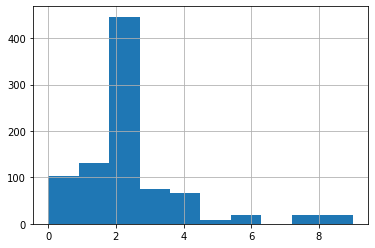

In [17]:
# Convert ticket number length values to bins
X_ticket_num = df['Ticket_len'].to_numpy().reshape(-1,1)
est2 = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_tick_num_t = est2.fit_transform(X_ticket_num)
df['Ticket_num_bin'] = X_tick_num_t
df['Ticket_num_bin'].hist()

In [18]:
pd.pivot_table(df,index=['Ticket_alpha','Ticket_num_bin'],columns=['Survived'],values=['PassengerId'],fill_value='-',aggfunc='count')

PassengerId       
Survived                              0      1
Ticket_alpha Ticket_num_bin                   
0            0.0                   66.0   37.0
             1.0                   50.0   81.0
             2.0                  294.0  137.0
a4           4.0                    7.0      -
a5           3.0                    6.0    1.0
             4.0                   13.0    1.0
as           3.0                    1.0      -
c            2.0                    3.0    2.0
ca           2.0                    6.0      -
             3.0                    7.0    1.0
             4.0                   14.0   13.0
casoton      8.0                    1.0      -
fa           4.0                    1.0      -
fc           4.0                    1.0      -
fcc          6.0                    1.0    4.0
pc           3.0                   21.0   39.0
pp           2.0                    1.0    2.0
ppp          4.0                    1.0    1.0
sc           2.0                      -    1.0
sca4         8.0                    1.0      -
scah         4.0                      -    1.0
             5.0                    1.0      -
scah basle   8.0                      -    1.0
scow         4.0                    1.0      -
scparis      6.0                    5.0    4.0
             8.0                    1.0    1.0
soc          4.0                      -    1.0
             6.0                    5.0      -
sop          5.0                    1.0      -
sopp         5.0                    2.0      -
             6.0                    1.0      -
sotono2      8.0                    2.0      -
sotonoq      8.0                    6.0    1.0
             9.0                    7.0    1.0
sp           4.0                    1.0      -
stono 2      9.0                    7.0    5.0
stono2       8.0                    3.0    3.0
swpp         4.0                      -    1.0
             5.0                      -    1.0
wc           4.0                    8.0      -
             5.0                    1.0    1.0
wep          4.0                    1.0    1.0
             5.0                    1.0      -

In [19]:
# Why do age null values overlap so much with cabin null values
print(
    'Cabin is null:',df[df['Cabin'].isna()].shape,
    '\nAge is null:',df[df['Age']==0].shape,
    '\nAge + Cabin:',df[(df['Age']==0)&(df['Cabin'].isna())].shape
     )

Cabin is null: (687, 22) 
Age is null: (184, 22) 
Age + Cabin: (164, 22)


<AxesSubplot:xlabel='SibSp'>

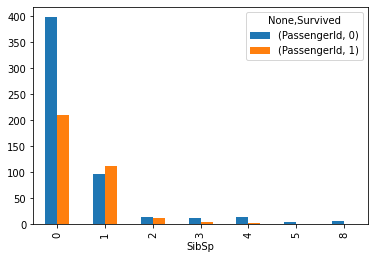

In [20]:
sib_pt = pd.pivot_table(df,index=['SibSp'],columns=['Survived'],values=['PassengerId'],fill_value=0,aggfunc='count')
sib_pt.plot.bar()

<AxesSubplot:ylabel='SibSp,Parch'>

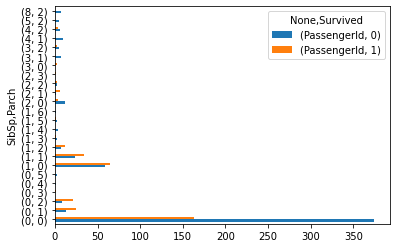

In [21]:
sib_parch_pt = pd.pivot_table(df,index=['SibSp','Parch'],columns=['Survived'],values=['PassengerId'],fill_value=0,aggfunc='count')
sib_parch_pt.plot.barh()

# sklearn OneHotEncoding approach

In [22]:
# Create DataFrame with needed columns and convert to single datatype for OneHotEncoding
dff = pd.DataFrame()
dff = df[['Survived','Embarked','Title','Ticket_alpha','Cabin_alpha','Pclass','SibSp','Parch']].copy().astype('str')
dff[['Ticket_num','Cabin_num']] = df[['Ticket_num','Cabin_num']].copy().astype('int')
dff['Fare'] = df['Fare'].copy().astype('float')
dff.head()

,Survived,Embarked,Title,Ticket_alpha,Cabin_alpha,Pclass,SibSp,Parch,Ticket_num,Cabin_num,Fare
0,0,S,Mr,a5,0,3,1,0,21171,0,7.2500
1,1,C,Mrs,pc,C,1,1,0,17599,85,71.2833
2,1,S,Miss,stono2,0,3,0,0,3101282,0,7.9250
3,1,S,Mrs,0,C,1,1,0,113803,123,53.1000
4,0,S,Mr,0,0,3,0,0,373450,0,8.0500


In [23]:
# Transform columns
ohe_features = ['Embarked','Title','Ticket_alpha','Cabin_alpha','Pclass','SibSp','Parch']
ohe_transformer = OneHotEncoder(handle_unknown='ignore')

scaler_features = ['Fare']
scaler_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

# kbin_features = ['Ticket_num','Cabin_num']
# kbin_transformer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Build out column transformer to pre-process training data
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe',ohe_transformer,ohe_features),
        ('scaler',scaler_transformer,scaler_features)
#         ('kbin',kbin_transformer,kbin_features)
                 ])

# Create pipeline and pass columns through
pipe = Pipeline(
    steps=[('preprocessor',preprocessor),
           ('classifier',LogisticRegression(solver='lbfgs',max_iter=400))])

# Paramgrid
param_grid = {
    'preprocessor__scaler__imputer__strategy':['mean','median'],
#     'preprocessor__kbin__strategy':['uniform','kmeans'],
#     'preprocessor__kbin__n_bins':[5,10,15],
#     'preprocessor__kbin__encode':['onehot','onehot-dense','ordinal'],
    'classifier__C':[0.1,1,10]
              }

# Define data (X) and labels (y) for passing through pipeline
X = dff[['Embarked','Title','Pclass','Ticket_alpha','Cabin_alpha','SibSp','Parch','Fare']]#,'Ticket_num','Cabin_num']]
y = dff['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

# Find best parameters
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)
print("Best params:")
print(grid_search.best_params_)
print('Best cross-validation score (f1_weighted):{:.3f}'.format(grid_search.best_score_))


# pipe.fit(X_train,y_train)
# y_pred = pipe.predict(X_test)
# print("model score: %.3f" % pipe.score(X_test, y_test))
# y_true = y_test
# y_pred = pipe.predict(X_test)
# target_names = dff['Survived'].unique().astype('str')
# print(classification_report(y_true, y_pred, target_names=target_names))

Best params:
{'classifier__C': 0.1, 'preprocessor__scaler__imputer__strategy': 'mean'}
Best cross-validation score (f1_weighted):0.808


In [24]:
# Pandas approach to OneHotEncoding
df_f = df[['PassengerId','Survived','SibSp','Parch','Pclass','Title_num','Ticket_num_bin','Cabin_num_bin','Ticket_alpha','Cabin_alpha','Embarked']]
s = pd.get_dummies(df_f,columns=['SibSp','Parch','Pclass','Title_num','Ticket_num_bin','Cabin_num_bin','Ticket_alpha','Cabin_alpha', 'Embarked'])
X_dum = s.iloc[:,2:]
y_dum = s.iloc[:,1]
X_train_dum,X_test_dum,y_train_dum,y_test_dum = train_test_split(X_dum,y_dum,random_state=42,stratify=y_dum)

# Check columns for dummies
print(s.columns)

Index(['PassengerId', 'Survived', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2',
       'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Title_num_0.0', 'Title_num_1.0', 'Title_num_2.0',
       'Title_num_3.0', 'Title_num_4.0', 'Title_num_5.0', 'Title_num_6.0',
       'Title_num_7.0', 'Title_num_8.0', 'Title_num_9.0', 'Title_num_10.0',
       'Title_num_11.0', 'Title_num_12.0', 'Title_num_13.0', 'Title_num_14.0',
       'Title_num_15.0', 'Title_num_16.0', 'Ticket_num_bin_0.0',
       'Ticket_num_bin_1.0', 'Ticket_num_bin_2.0', 'Ticket_num_bin_3.0',
       'Ticket_num_bin_4.0', 'Ticket_num_bin_5.0', 'Ticket_num_bin_6.0',
       'Ticket_num_bin_8.0', 'Ticket_num_bin_9.0', 'Cabin_num_bin_0.0',
       'Cabin_num_bin_1.0', 'Cabin_num_bin_2.0', 'Cabin_num_bin_3.0',
       'Cabin_num_bin_4.0', 'Cabin_num_bin_5.0', 'Cabin_num_bin_6.0',
       'Cabin_num_bin_7.0', 'Cabin_num_bin_8.0', 'C

In [25]:
# Pass data through model and predict
clf = LogisticRegression()
clf.fit(X_train_dum, y_train_dum)
y_true = y_test_dum
y_pred = clf.predict(X_test_dum)
target_names = s['Survived'].unique().astype('str')
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       137
           1       0.70      0.72      0.71        86

    accuracy                           0.77       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.77      0.77      0.77       223



# Graveyard